# COVID-19 Literature Clustering

# Goal
Given the large number of research literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. So, clustering similar research articles together can simplify the search for related publications. By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot.

On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster. By using Bokeh, the plot will be interactive. User’s will have the option of seeing the plot as a whole or filtering the data by cluster.

If a narrower scope is required, the plot will also have a search function which will limit the output to only papers containing the search term. Hovering over points on the plot will give basic information like title, author, journal, and abstract. Clicking on a point will bring up a menu with a URL that can be used to access the full publication.

The fundamental purpose is to make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations using the CORD-19 dataset.
<br>
<br>

# Approach:
- Parse the text from the body of each document using Natural Language Processing.
- Turn each document instance into a feature vector $X_i$ using Term Frequency–inverse Document Frequency.
- Apply Dimensionality Reduction to each feature vector using t-Distributed Stochastic Neighbor Embedding to cluster similar research articles in the two dimensional plane.
- Use Principal Component Analysis (PCA) to project down the dimensions of $X$ to a number of dimensions that will keep .95 variance while removing noise and outliers.
- Apply k-means clustering where $k$ value is to determined by elbow method or Silhouette Algorithm to label each cluster.
- Apply Topic Modeling on $X$ using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster. 
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD). 
<br>
<br>

# Table of Contents(So Far)
1. Loading the data
2. Pre-processing
3. Vectorization

<br>
<br>

### Dataset Description

>In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 51,000 scholarly articles, including over 40,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.
>#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

<br>
<br>

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import matplotlib.pyplot as plt

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [2]:
root_path = '/Users/avinashshanker/Desktop/UTAMasters/DataMining/COVID19-Literature-Clustering-master/data/'
metadata_path = f'{root_path}/metadata.csv'
plt.style.use('ggplot')
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/Users/avinashshanker/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210537 entries, 0 to 210536
Data columns (total 19 columns):
cord_uid            210537 non-null object
sha                 88257 non-null object
source_x            210537 non-null object
title               210481 non-null object
doi                 148804 non-null object
pmcid               93453 non-null object
pubmed_id           125599 non-null object
license             210537 non-null object
abstract            149527 non-null object
publish_time        210519 non-null object
authors             203810 non-null object
journal             198453 non-null object
mag_id              0 non-null float64
who_covidence_id    59405 non-null object
arxiv_id            2844 non-null object
pdf_json_files      88257 non-null object
pmc_json_files      68191 non-null object
url                 163141 non-null object
s2_id               181154 non-null float64
dtypes: float64(2), object(17)
memory usage: 30.5+ MB


### Fetch All of JSON File Path

Here, I am getting all the JSON files

In [4]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

294

### Helper Functions Declarations
1. Here, JSON files are parsed
2. Then FileReader function return paperID, abstract and its body

In [5]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

041428cc59d31e9134431bc93eb0493db0a22187: ... for patients with confirmed and (vi) the variability in assessing the number of deaths per day, for example the number of deaths mentioned in France corresponds to the number of deaths in hospital. Wh...


##### More Helper Functions
1. Helper function adds break after every n words using an html tag for break

2. This is for the interactive plot so that hover tool fits the screen

In [6]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

## Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [7]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 294
Processing index: 29 of 294
Processing index: 58 of 294
Processing index: 87 of 294
Processing index: 116 of 294
Processing index: 145 of 294
Processing index: 174 of 294
Processing index: 203 of 294
Processing index: 232 of 294
Processing index: 261 of 294
Processing index: 290 of 294


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,041428cc59d31e9134431bc93eb0493db0a22187,10.1093/eurheartj/ehaa282,,for patients with confirmed and (vi) the varia...,"Gaye, Bamba. Fanidi, Anouar. Jouven, Xavier",Denominator matters in estimating COVID-19<br...,Eur Heart J,Not provided.
1,e319b85c3756cf7545dba79fcc24fd6e5722dc54,10.1016/j.ijcard.2020.05.081,,J o u r n a l P r e -p r o o f Dear Dr. Müller...,"Tan, Weiyi. Aboulhosn, Jamil","Response to the letter, “The cardiovascular<b...",Int J Cardiol,Not provided.
2,d389175f2655317284484a9f86a30cf6963b2bf2,10.1016/s0140-6736(20)31489-6,,This financial crisis could not have occurred ...,"King, Arlene. Andrus, Jon Kim. Figueroa, J<...",Financial crisis at PAHO in the time of<br>CO...,Lancet,Not provided.
3,836c35eebda0eb820560f8383e5d5492f67d473d,10.1097/acm.0000000000003425,,To the Editor: The COVID-19 pandemic has disru...,"Samarasekera, Dujeepa D.. Goh, Denise Li Men...",Medical School Approach to Manage the Current...,Acad Med,Not provided.
4,22010a8cb807af4725c06722dbf39646869c1482,10.1001/jamainternmed.2020.1369,,"Between March 14-16 2020 (a 48-hour period), w...","Nelson, Lorene M.. Simard, Julia F.. Oluyom...",US Public Concerns About the COVID-19 Pandemi...,JAMA Internal Medicine,Not provided.


<br>

## Some feature engineering

Adding word count columns for both abstract and body_text can be useful parameters later:

In [8]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,041428cc59d31e9134431bc93eb0493db0a22187,10.1093/eurheartj/ehaa282,,for patients with confirmed and (vi) the varia...,"Gaye, Bamba. Fanidi, Anouar. Jouven, Xavier",Denominator matters in estimating COVID-19<br...,Eur Heart J,Not provided.,0,151,107
1,e319b85c3756cf7545dba79fcc24fd6e5722dc54,10.1016/j.ijcard.2020.05.081,,J o u r n a l P r e -p r o o f Dear Dr. Müller...,"Tan, Weiyi. Aboulhosn, Jamil","Response to the letter, “The cardiovascular<b...",Int J Cardiol,Not provided.,0,254,158
2,d389175f2655317284484a9f86a30cf6963b2bf2,10.1016/s0140-6736(20)31489-6,,This financial crisis could not have occurred ...,"King, Arlene. Andrus, Jon Kim. Figueroa, J<...",Financial crisis at PAHO in the time of<br>CO...,Lancet,Not provided.,0,310,192
3,836c35eebda0eb820560f8383e5d5492f67d473d,10.1097/acm.0000000000003425,,To the Editor: The COVID-19 pandemic has disru...,"Samarasekera, Dujeepa D.. Goh, Denise Li Men...",Medical School Approach to Manage the Current...,Acad Med,Not provided.,0,422,260
4,22010a8cb807af4725c06722dbf39646869c1482,10.1001/jamainternmed.2020.1369,,"Between March 14-16 2020 (a 48-hour period), w...","Nelson, Lorene M.. Simard, Julia F.. Oluyom...",US Public Concerns About the COVID-19 Pandemi...,JAMA Internal Medicine,Not provided.,0,181,127


In [9]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 11 columns):
paper_id               188 non-null object
doi                    188 non-null object
abstract               188 non-null object
body_text              188 non-null object
authors                156 non-null object
title                  188 non-null object
journal                185 non-null object
abstract_summary       188 non-null object
abstract_word_count    188 non-null int64
body_word_count        188 non-null int64
body_unique_words      188 non-null int64
dtypes: int64(3), object(8)
memory usage: 16.3+ KB


In [10]:
df_covid['abstract'].describe(include='all')

count     188
unique     11
top          
freq      178
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [11]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     187
unique     11
top          
freq      177
Name: abstract, dtype: object

In [12]:
df_covid['body_text'].describe(include='all')

count         187
unique        187
top       Report 
freq            1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [13]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,041428cc59d31e9134431bc93eb0493db0a22187,10.1093/eurheartj/ehaa282,,for patients with confirmed and (vi) the varia...,"Gaye, Bamba. Fanidi, Anouar. Jouven, Xavier",Denominator matters in estimating COVID-19<br...,Eur Heart J,Not provided.,0,151,107
1,e319b85c3756cf7545dba79fcc24fd6e5722dc54,10.1016/j.ijcard.2020.05.081,,J o u r n a l P r e -p r o o f Dear Dr. Müller...,"Tan, Weiyi. Aboulhosn, Jamil","Response to the letter, “The cardiovascular<b...",Int J Cardiol,Not provided.,0,254,158
2,d389175f2655317284484a9f86a30cf6963b2bf2,10.1016/s0140-6736(20)31489-6,,This financial crisis could not have occurred ...,"King, Arlene. Andrus, Jon Kim. Figueroa, J<...",Financial crisis at PAHO in the time of<br>CO...,Lancet,Not provided.,0,310,192
3,836c35eebda0eb820560f8383e5d5492f67d473d,10.1097/acm.0000000000003425,,To the Editor: The COVID-19 pandemic has disru...,"Samarasekera, Dujeepa D.. Goh, Denise Li Men...",Medical School Approach to Manage the Current...,Acad Med,Not provided.,0,422,260
4,22010a8cb807af4725c06722dbf39646869c1482,10.1001/jamainternmed.2020.1369,,"Between March 14-16 2020 (a 48-hour period), w...","Nelson, Lorene M.. Simard, Julia F.. Oluyom...",US Public Concerns About the COVID-19 Pandemi...,JAMA Internal Medicine,Not provided.,0,181,127


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [14]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,187.000000,187.000000,187.000000
mean,5.780749,228.700535,146.251337
std,31.205701,133.739741,76.087569
min,0.000000,1.000000,1.000000
25%,0.000000,120.500000,84.500000
50%,0.000000,222.000000,146.000000
75%,0.000000,336.000000,209.500000
max,256.000000,662.000000,351.000000


# Data Pre-processing

In [15]:
#rename to df for ease of use
df = df_covid
del df_covid

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [16]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 187
Data columns (total 11 columns):
paper_id               156 non-null object
doi                    156 non-null object
abstract               156 non-null object
body_text              156 non-null object
authors                156 non-null object
title                  156 non-null object
journal                156 non-null object
abstract_summary       156 non-null object
abstract_word_count    156 non-null int64
body_word_count        156 non-null int64
body_unique_words      156 non-null int64
dtypes: int64(3), object(8)
memory usage: 14.6+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [17]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 156/156 [00:01<00:00, 149.28it/s]


In [18]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 156

{'af': 1, 'cy': 2, 'de': 2, 'en': 142, 'es': 3, 'fr': 5, 'tl': 1}


Lets take a look at the language distribution in the dataset

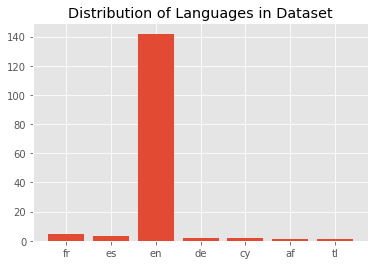

In [19]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [20]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 187
Data columns (total 12 columns):
paper_id               142 non-null object
doi                    142 non-null object
abstract               142 non-null object
body_text              142 non-null object
authors                142 non-null object
title                  142 non-null object
journal                142 non-null object
abstract_summary       142 non-null object
abstract_word_count    142 non-null int64
body_word_count        142 non-null int64
body_unique_words      142 non-null int64
language               142 non-null object
dtypes: int64(3), object(9)
memory usage: 14.4+ KB


Download the spacy bio parser. <br>
io is used to hide the messy download

In [21]:
from IPython.utils import io

with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

In [22]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

/Users/avinashshanker/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [23]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['seemed',
 'through',
 'somehow',
 'go',
 'beside',
 'across',
 'part',
 'amount',
 'further',
 'hers']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [24]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [25]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [26]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

/Users/avinashshanker/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 142/142 [00:02<00:00, 52.47it/s]


### Let's take a look at word count in the papers

In [27]:
import seaborn as sns

count    142.000000
mean     229.852113
std      130.844011
min        3.000000
25%      124.750000
50%      221.500000
75%      332.500000
max      662.000000
Name: body_word_count, dtype: float64

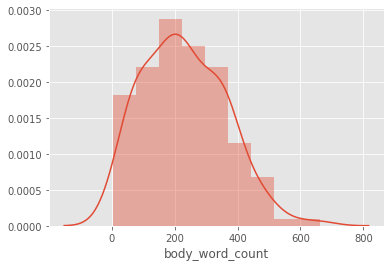

In [28]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count    142.000000
mean     148.478873
std       74.590106
min        3.000000
25%       88.250000
50%      144.500000
75%      210.000000
max      351.000000
Name: body_unique_words, dtype: float64

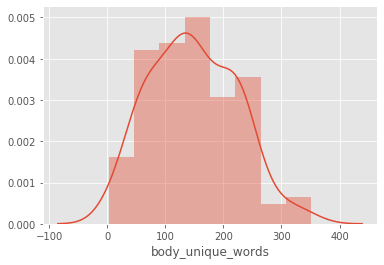

In [29]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [31]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(142, 4096)

# Next steps.. PCA  & Clustering
1. Next we need to see how much we can reduce the dimensions while still keeping high variance.
2. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means.